In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, BertTokenizer, BertModel
import torch, re, json, jieba
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from pyecharts.charts import Scatter
from pyecharts.charts import Bar
from pyecharts.charts import Geo
from pyecharts.charts import WordCloud
from pyecharts.globals import SymbolType
from pyecharts.globals import ChartType
from pyecharts.charts import Pie
from pyecharts import options as opts
from pyecharts.faker import Faker
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib as mpl
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from analysis_utils import get_position_types

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
MODEL_PATH = '../models/model_zoo/medium'
# MODEL_PATH = '/home/vmice/projects/sbert-base-chinese-nli'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = SentenceTransformer(MODEL_PATH, device=device)

test_sentences = ['我想要去加入一个经常旅游的团队，因为我喜欢旅游。',
                  '我们团队平时会偶尔去旅游的。',
                  '经常去旅游的团队我不喜欢去。']
# input_ = tokenizer(test_sentences, truncation=True, return_tensors="pt")
# input_
test_sentences = model.encode(test_sentences)
util.cos_sim(test_sentences, test_sentences)

No sentence-transformers model found with name ../models/model_zoo/medium. Creating a new one with MEAN pooling.
Some weights of BertModel were not initialized from the model checkpoint at ../models/model_zoo/medium and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[1.0000, 0.6602, 0.3318],
        [0.6602, 1.0000, 0.3214],
        [0.3318, 0.3214, 1.0000]])

In [4]:
job_csv_file = '../datasets/result1-1.csv'

job_data = pd.read_csv(job_csv_file, encoding='GBK')
print('job data shape', job_data.shape)

job data shape (1254, 14)


In [5]:
job_data.head(3)

,序号,招聘信息 ID,企业名称,企业类型,招聘岗位,薪资范围,招募类型,期望学历,工作年数,招募人数,岗位类型,技能需求,公司地址,工作福利
0,1,1631112859897430016,深圳市海柔创新科技有限公司,"['电子商务', '互联网']",技术服务工程师,"[5000, 10000]",全职,大专,不限,5,"['互联网', '人工智能']",[],广东省深圳市,"['餐饮补贴', '专业培训', '弹性工作']"
1,2,1629824814967554048,广州太普软件科技有限公司,"['互联网', '软件']",大数据分析师（BI）,"[4500, 7000]",全职,本科,不限,1,"['互联网', '软件']",[],广东省广州市,"['餐饮补贴', '专业培训', '弹性工作']"
2,3,1613439889204969472,广州奇之信息技术有限公司,"['互联网', '数据服务']",自然语言处理工程师,"[2000, 4000]",实习,本科,不限,0,['自然语言'],"['算法研究', '深度学习']",广东省广州市,[]


## 招聘信息

### 岗位类型

In [6]:
position_data_items = job_data['招聘岗位'].unique().tolist()
position_data_dict = get_position_types(position_data_items)

position_counter = job_data['招聘岗位'].value_counts()
position_counter_index = position_counter.index.to_list()
position_counter_count_dict = {index: int(position_counter[index]) for index in position_counter_index}

print(len(position_data_dict), len(position_counter_count_dict))

591 591


In [7]:
position_dict = {} # kind: count
for position_name, position_item in position_data_dict.items():
    position_type = position_item['type'].split('-')[0]
    if position_type not in position_dict: position_dict[position_type] = 0
    position_dict[position_type] += position_counter_count_dict[position_name]

position_dict

{'技术': 956, '运营': 23, '其他': 50, '产品': 184, '职能': 6, '市场': 35}

In [8]:
position_pie = (
    Pie(init_opts=opts.InitOpts(width="900px", height="600px"))
    .add("", [list(z) for z in zip(list(position_dict.keys()), position_dict.values())])
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    .set_global_opts(
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts={"text": "公司类型"}
    )
)
position_pie.render_notebook()

In [9]:
position_dict = {} # kind: count
for position_name, position_item in position_data_dict.items():
    position_type = position_item['type'].split('-')[0]
    if position_type not in ['技术', '产品']: continue
    position_type = position_item['type'].split('-')[1]
    if position_type not in position_dict: position_dict[position_type] = 0
    position_dict[position_type] += position_counter_count_dict[position_name]

position_dict

{'其他': 44,
 '数据科学': 708,
 '人工智能': 79,
 '管理': 193,
 '运维': 10,
 '数据库': 35,
 '开发': 34,
 '基础': 7,
 '硬件': 8,
 '测试': 22}

In [10]:
position_pie = (
    Pie(init_opts=opts.InitOpts(width="900px", height="600px"))
    .add("", [list(z) for z in zip(list(position_dict.keys()), position_dict.values())])
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}：{c}"))
    .set_global_opts(
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts={"text": "公司类型"}
    )
)
position_pie.render_notebook()

### 学历要求

In [11]:
# edu_counter = job_data['期望学历'].value_counts()
# edu_counter_index = edu_counter.index.to_list()

# edu_sorted_index = ['不限', '技工', '大专', '本科', '硕士']
# edu_counter_count = [int(edu_counter[index]) for index in edu_sorted_index]
# edu_sorted_index, edu_counter_count

In [12]:
edu_counter = job_data.loc[:, ['招聘岗位', '期望学历']]
edu_counter_dict = {}
for idx in range(edu_counter.shape[0]):
    position_name = edu_counter.iloc[idx].values[0]
    demand_count = edu_counter.iloc[idx].values[1]
    if position_name not in edu_counter_dict: 
        edu_counter_dict[position_name] = {
            "不限": 0, "技工": 0, "大专": 0, "本科": 0, "硕士": 0
        }
    edu_counter_dict[position_name][demand_count] += 1
# edu_counter = job_data.loc[:, ['招聘岗位', '期望学历']]
 
len(edu_counter_dict)

591

In [13]:
edu_dict = {} # kind: count
for position_name, position_item in position_data_dict.items():
    position_type = position_item['type'].split('-')[0]
    if position_type not in edu_dict: edu_dict[position_type] = [0, 0, 0, 0, 0]
    for idx, (demand_count, edu_count) in enumerate(edu_counter_dict[position_name].items()):
        edu_dict[position_type][idx] += edu_count

edu_dict

{'技术': [2, 2, 165, 749, 38],
 '运营': [1, 1, 9, 9, 3],
 '其他': [5, 3, 10, 32, 0],
 '产品': [0, 1, 15, 168, 0],
 '职能': [0, 0, 2, 4, 0],
 '市场': [1, 2, 14, 18, 0]}

In [14]:
# position_data_dict, position_counter_count_dict
edu_bar = (
    Bar(init_opts=opts.InitOpts(width="800px", height="600px"))
    .add_xaxis(list(edu_dict.keys()))
    # .add_yaxis('不限', [item[0] for _, item in edu_dict.items()])
    # .add_yaxis('技工', [item[1] for _, item in edu_dict.items()])
    # .add_yaxis('大专', [item[2] for _, item in edu_dict.items()])
    .add_yaxis('大专及以下', [int(np.sum(item[:3])) for _, item in edu_dict.items()])
    .add_yaxis('本科', [item[3] for _, item in edu_dict.items()])
    .add_yaxis('硕士', [item[4] for _, item in edu_dict.items()])
    .set_global_opts(
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts={"text": "学历要求"}
    )
)
edu_bar.render_notebook()

In [15]:
edu_dict = {} # kind: count
for position_name, position_item in position_data_dict.items():
    position_type = position_item['type'].split('-')[0]
    if position_type not in ['技术', '产品']: continue
    position_type = position_item['type'].split('-')[1]
    if position_type not in edu_dict: edu_dict[position_type] = [0, 0, 0, 0, 0]
    for idx, (demand_count, edu_count) in enumerate(edu_counter_dict[position_name].items()):
        edu_dict[position_type][idx] += edu_count

edu_dict

{'其他': [0, 0, 10, 33, 1],
 '数据科学': [2, 1, 125, 571, 9],
 '人工智能': [0, 0, 6, 48, 25],
 '管理': [0, 0, 17, 176, 0],
 '运维': [0, 1, 8, 1, 0],
 '数据库': [0, 0, 7, 28, 0],
 '开发': [0, 0, 3, 28, 3],
 '基础': [0, 1, 1, 5, 0],
 '硬件': [0, 0, 1, 7, 0],
 '测试': [0, 0, 2, 20, 0]}

In [16]:
# position_data_dict, position_counter_count_dict
edu_bar = (
    Bar(init_opts=opts.InitOpts(width="800px", height="600px"))
    .add_xaxis(list(edu_dict.keys()))
    # .add_yaxis('不限', [item[0] for _, item in edu_dict.items()])
    # .add_yaxis('技工', [item[1] for _, item in edu_dict.items()])
    .add_yaxis('大专及以下', [int(np.sum(item[:3])) for _, item in edu_dict.items()])
    .add_yaxis('本科', [item[3] for _, item in edu_dict.items()])
    .add_yaxis('硕士', [item[4] for _, item in edu_dict.items()])
    .set_global_opts(
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts={"text": "学历要求"})
)
edu_bar.render_notebook()

### 岗位需求量

In [17]:
demand_counter = job_data.loc[:, ['招聘岗位', '招募人数']] 
demand_counter_dict = {}
for idx in range(demand_counter.shape[0]):
    position_name = demand_counter.iloc[idx].values[0]
    demand_count = demand_counter.iloc[idx].values[1]
    if position_name not in demand_counter_dict: 
        demand_counter_dict[position_name] = 0
    demand_counter_dict[position_name] += int(demand_count)

# demand_counter_dict = {key: value for key, value in demand_counter_dict.items() if value > 0}
len(demand_counter_dict)

591

In [18]:
demand_dict = {} # kind: count
for position_name, position_item in position_data_dict.items():
    if demand_counter_dict[position_name] == 0: continue
    position_type = position_item['type'].split('-')[0]
    # if position_type not in ['技术', '产品']: continue
    # position_type = position_item['type'].split('-')[1]
    if position_type not in demand_dict: demand_dict[position_type] = 0
    demand_dict[position_type] += demand_counter_dict[position_name]

demand_dict

{'技术': 2855, '产品': 447, '职能': 6, '运营': 125, '市场': 419, '其他': 238}

In [19]:
demand_pie = (
    Pie(init_opts=opts.InitOpts(width="800px", height="600px"))
    .add("", [list(z) for z in zip(list(demand_dict.keys()), demand_dict.values())])
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    .set_global_opts(
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts={"text": "岗位需求量"}
    )
)
demand_pie.render_notebook()

In [20]:
demand_dict = {} # kind: count
for position_name, position_item in position_data_dict.items():
    if demand_counter_dict[position_name] == 0: continue
    position_type = position_item['type'].split('-')[0]
    if position_type not in ['技术', '产品', '市场']: continue
    position_type = position_item['type'].split('-')[1]
    if position_type not in demand_dict: demand_dict[position_type] = 0
    demand_dict[position_type] += demand_counter_dict[position_name]

demand_dict

{'其他': 191,
 '数据科学': 1932,
 '人工智能': 235,
 '管理': 489,
 '运维': 37,
 '数据库': 76,
 '开发': 230,
 '服务': 167,
 '基础': 23,
 '硬件': 70,
 '销售': 198,
 '测试': 73}

In [21]:
demand_pie = (
    Pie(init_opts=opts.InitOpts(width="1100px", height="600px"))
    .add("", [list(z) for z in zip(list(demand_dict.keys()), demand_dict.values())])
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    .set_global_opts(
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts={"text": "岗位需求量"}
    )
)
demand_pie.render_notebook()

### 公司类型

In [22]:
company_counter = job_data['企业类型'].value_counts()
company_counter_index = company_counter.index.to_list()
company_counter_count = [int(company_counter[index]) for index in company_counter_index]
# company_counter_index

In [23]:
company_sorted_dict_ = {} # {label: count}

for idx, company_types in enumerate(company_counter_index):
    company_types = eval(company_types)
    for company_type in company_types:
        if company_type not in company_sorted_dict_:
            company_sorted_dict_[company_type] = 0
        company_sorted_dict_[company_type] += company_counter_count[idx]
    
_company_count_thr = 10
company_sorted_dict = {'其他': 0}
company_other_types = []
for key, value in company_sorted_dict_.items():
    if value < _company_count_thr:
        company_sorted_dict['其他'] += value
        company_other_types.append(key)
    else:
        company_sorted_dict.update({key: value})

print('其他', company_other_types)
print(list(company_sorted_dict.keys()))
print(company_sorted_dict.values())

其他 ['金融', '计算机软件', '计算机', '医疗', '通讯', '服饰', '制造', '通信', '教育', '物流', '人力资源服务', '企业服务', '地产', '水利', '家电', '家居', '游戏', '在线教育', '环境', '机械', '医疗健康', '不限', '计量', '广告', '电子信息']
['其他', '互联网', '电子商务', '软件', '大数据', '电商', '数据服务', '智能硬件', '通信设备']
dict_values([66, 1238, 120, 53, 39, 23, 26, 11, 11])


In [24]:
demand_pie = (
    Pie(init_opts=opts.InitOpts(width="900px", height="600px"))
    .add("", [list(z) for z in zip(list(company_sorted_dict.keys()), company_sorted_dict.values())])
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    .set_global_opts(
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts={"text": "公司类型"}
    )
)
demand_pie.render_notebook()

### 薪资待遇

In [25]:
wage_counter = job_data.loc[:, ['招聘岗位', '薪资范围', '期望学历']]
wage_counter_dict = {}
for idx in range(wage_counter.shape[0]):
    position_name = wage_counter.iloc[idx].values[0]
    wage_count = wage_counter.iloc[idx].values[1]
    edu_type = wage_counter.iloc[idx].values[2]
    if position_name not in wage_counter_dict: 
        wage_counter_dict[position_name] = [[], [], []]
    if edu_type == '硕士':
        wage_counter_dict[position_name][-1].append(np.mean(eval(wage_count)))
    elif edu_type == '本科':
        wage_counter_dict[position_name][1].append(np.mean(eval(wage_count)))
    else:
        wage_counter_dict[position_name][0].append(np.mean(eval(wage_count)))

wage_counter_dict = {position_name: [
                count if len(count) != 0 else [0] for count in counts
    ] for position_name, counts in wage_counter_dict.items()}
len(wage_counter_dict)

591

In [26]:
wage_dict = {} # kind: count
for position_name, position_item in position_data_dict.items():
    position_type = position_item['type'].split('-')[0]
    # if position_type not in ['技术', '产品']: continue
    # position_type = position_item['type'].split('-')[1]
    if position_type not in wage_dict: wage_dict[position_type] = [[], [], []]
    for k in range(3):
        mean_wage = np.mean(wage_counter_dict[position_name][k])
        if mean_wage != 0: wage_dict[position_type][k].append(mean_wage)

wage_dict = {position_type: [
                count if len(count) != 0 else [0] for count in counts
    ] for position_type, counts in wage_dict.items()}

wage_dict = {position_type:
                [float(np.round(np.mean(counts), 2)) for counts in counts_list]
    for position_type, counts_list in wage_dict.items()}
wage_dict

{'技术': [10543.71, 15753.08, 24247.13],
 '运营': [13671.88, 9781.25, 27000.0],
 '其他': [7527.78, 10771.55, 0.0],
 '产品': [13526.52, 19787.3, 0.0],
 '职能': [7000.0, 9312.5, 0.0],
 '市场': [8621.25, 11029.41, 0.0]}

In [27]:
# position_data_dict, position_counter_count_dict
wage_bar = (
    Bar(init_opts=opts.InitOpts(width="800px", height="600px"))
    .add_xaxis(list(wage_dict.keys()))
    .add_yaxis('大专及以下', [item[0] for _, item in wage_dict.items()])
    .add_yaxis('本科', [item[1] for _, item in wage_dict.items()])
    .add_yaxis('硕士', [item[2] for _, item in wage_dict.items()])
    .set_global_opts(
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts={"text": "平均薪资"})
)
wage_bar.render_notebook()

In [28]:
# position_data_dict, position_counter_count_dict
wage_bar = (
    Bar(init_opts=opts.InitOpts(width="800px", height="600px"))
    .add_xaxis(list(wage_dict.keys()))
    .add_yaxis('全部', [np.around(np.sum(wages) / np.sum(np.array(wages) > 0), 2)
                      for _, wages in wage_dict.items()])
    .set_global_opts(
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts={"text": "平均薪资"})
)
wage_bar.render_notebook()

In [29]:
wage_dict = {} # kind: count
for position_name, position_item in position_data_dict.items():
    position_type = position_item['type'].split('-')[0]
    if position_type not in ['技术', '产品',  '运营']: continue
    position_type = position_item['type'].split('-')[1]
    if position_type not in wage_dict: wage_dict[position_type] = [[], [], []]
    for k in range(3):
        mean_wage = np.mean(wage_counter_dict[position_name][k])
        if mean_wage != 0: wage_dict[position_type][k].append(mean_wage)

wage_dict = {position_type: [
                count if len(count) != 0 else [0] for count in counts
    ] for position_type, counts in wage_dict.items()}

wage_dict = {position_type:
                [float(np.round(np.mean(counts), 2)) for counts in counts_list]
    for position_type, counts_list in wage_dict.items()}
wage_dict

{'其他': [10020.83, 10244.67, 15000.0],
 '数据科学': [10085.21, 15912.26, 20083.33],
 '人工智能': [11666.67, 24207.96, 26719.3],
 '基础': [7958.33, 7974.38, 0.0],
 '管理': [17920.14, 20057.29, 27000.0],
 '运维': [7265.62, 22500.0, 0.0],
 '数据库': [17714.29, 15961.46, 0.0],
 '开发': [10250.0, 11418.18, 20000.0],
 '硬件': [10000.0, 9857.14, 0.0],
 '测试': [6750.0, 7695.83, 0.0]}

In [30]:
# position_data_dict, position_counter_count_dict
wage_bar = (
    Bar(init_opts=opts.InitOpts(width="800px", height="600px"))
    .add_xaxis(list(wage_dict.keys()))
    .add_yaxis('大专及以下', [item[0] for _, item in wage_dict.items()])
    .add_yaxis('本科', [item[1] for _, item in wage_dict.items()])
    .add_yaxis('硕士', [item[2] for _, item in wage_dict.items()])
    .set_global_opts(
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts={"text": "平均薪资"})
)
wage_bar.render_notebook()

In [31]:
# position_data_dict, position_counter_count_dict
wage_bar = (
    Bar(init_opts=opts.InitOpts(width="800px", height="600px"))
    .add_xaxis(list(wage_dict.keys()))
    .add_yaxis('全部', [np.around(np.sum(wages) / np.sum(np.array(wages) > 0), 2)
                      for _, wages in wage_dict.items()])
    .set_global_opts(
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts={"text": "平均薪资"})
)
wage_bar.render_notebook()

### 岗位技能

In [32]:
skill_counter = job_data.loc[:, ['招聘岗位', '技能需求']]
skill_counter = [eval(skill) for skill in skill_counter.loc[:, '技能需求'].to_list() if len(eval(skill)) > 0]

skill_counter_dict = {}
for skills in skill_counter:
    for skill in skills:
        if skill not in skill_counter_dict: 
            skill_counter_dict[skill] = 0
        skill_counter_dict[skill] += 1

len(skill_counter_dict)

111

In [33]:
skill_word = (
    WordCloud(init_opts=opts.InitOpts(width="800px", height="600px"))
    .add(series_name="skills", 
         data_pair=[(name, count) for name, count in skill_counter_dict.items()], 
         word_size_range=[6, 66],
         shape='circle',
        )
    .set_global_opts(
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts={"text": "岗位技能"})
)
skill_word.render_notebook()

### 工作地点

In [34]:
addr_counter = job_data.loc[:, ['招聘岗位', '公司地址']]
addr_counter_dict = {}
for idx in range(addr_counter.shape[0]):
    position_name = addr_counter.iloc[idx].values[0]
    position_addr = addr_counter.iloc[idx].values[1]
    if not isinstance(position_addr, str): continue
    # print(position_addr)
    position_addr = re.findall(r'(.*?(省|市))', position_addr)[0][0]
    if position_addr not in addr_counter_dict: 
        addr_counter_dict[position_addr] = 0
    addr_counter_dict[position_addr] += 1
# edu_counter = job_data.loc[:, ['招聘岗位', '期望学历']]
 
addr_counter_dict

{'广东省': 1161,
 '湖北省': 3,
 '四川省': 8,
 '北京市': 7,
 '福建省': 1,
 '江苏省': 2,
 '重庆市': 1,
 '上海市': 8,
 '山东省': 5,
 '贵州省': 1,
 '辽宁省': 2,
 '江西省': 1,
 '河南省': 1,
 '浙江省': 3,
 '湖南省': 4}

In [35]:
c = (
    Geo(init_opts=opts.InitOpts(width="800px", height="600px"))
    .add_schema(maptype="china")
    .add("城市", 
         [list(z) for z in zip(
            list(addr_counter_dict.keys()), 
            list(addr_counter_dict.values()))],
            # type_=ChartType.HEATMAP,
    )
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(
        visualmap_opts=opts.VisualMapOpts(),
        toolbox_opts=opts.ToolboxOpts(is_show=True),
        title_opts=opts.TitleOpts(title="公司地点"),
    )
)
c.render_notebook()

## 岗位相关度分析

In [36]:
POSITION_TYPE_FILE = './position_type.json'
with open(POSITION_TYPE_FILE, 'r') as f:
    content = f.read()
position_type = json.loads(content)
position_type_ = {}

def _get_item_infos(type_name, dict_item):
    if isinstance(dict_item, list): 
        position_type_[type_name] = dict_item
    elif isinstance(dict_item, dict):
        for vice_type_name, item in dict_item.items():
            _get_item_infos(type_name + '-' + vice_type_name, item)

for main_type_name, item in position_type.items():
    _get_item_infos(main_type_name, item)

# position_type_

In [37]:
def _get_position_type(position_name):
    for position_type, items in position_type_.items():
        for item in items:
            # print(position_name, item)
            if len(re.findall(re.compile(item), position_name)) == 0: continue
            return position_type

position_data_items = job_data['招聘岗位'].unique().tolist()

position_data_dict = get_position_types(position_data_items)

position_data_items = []
for position_name, item in position_data_dict.items():
    position_type = _get_position_type(item['simplify'])
    position_data_items.append(item['simplify'])
    position_data_dict[position_name]['type'] = position_type

position_data_items = np.unique(position_data_items)
len(position_data_items)

383

In [38]:
data_sentences = model.encode(position_data_items)

In [39]:
# 聚类
km_total, distortion = 40, []
for i in range(1, km_total):
    km = KMeans(n_clusters=i,
             init='k-means++',
            #  algorithm='elkan',
             random_state=8)
    km.fit(data_sentences)
    distortion.append(km.inertia_)
# print(Kmeans.n_iter_, Kmeans.inertia_)

# dbModel = DBSCAN(eps=0.003, min_samples=2).fit(data_sentences)

# clustering = DBSCAN(eps=9.5, min_samples=2).fit(data_sentences)
# clustering.labels_
# print(dbModel.labels_)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Text(0, 0.5, 'Distortion')

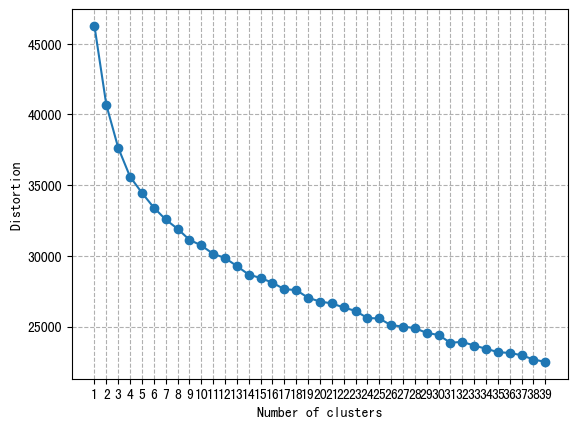

In [40]:
plt.plot(range(1, km_total), distortion, marker='o')
plt.xticks(range(1, km_total))
plt.grid(linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

In [41]:
Kmeans = KMeans(n_clusters=10, init="k-means++", algorithm='elkan').fit(data_sentences)
labels = Kmeans.labels_ 

In [42]:
# pca = PCA(n_components=2, svd_solver='randomized', random_state=0) #实例化
# pca = pca.fit(data_sentences) #拟合模型
# visual = pca.transform(data_sentences) #获取新矩阵

visual_model = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, method='exact')
# visual_model = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=0, method='exact')
# visual_model = TSNE(n_components=2, learning_rate='auto', init='random', 
#                     perplexity=40, early_exaggeration=20.0, method='exact')
visual = visual_model.fit_transform(data_sentences)

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
visual = scaler.fit_transform(visual)

# Kmeans = KMeans(n_clusters=len(position_classes)).fit(visual)
# labels = Kmeans.labels_ 

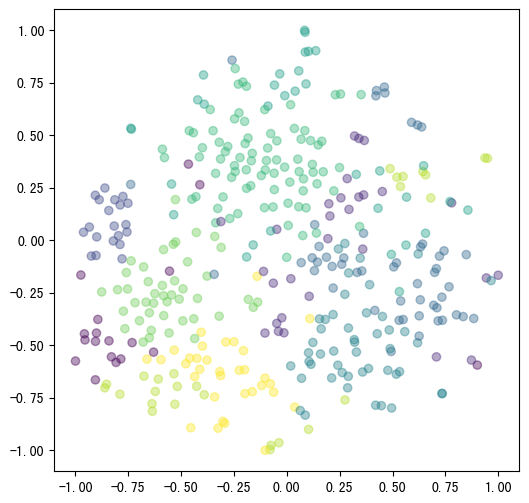

In [43]:
colors = ['r', 'g', 'w', 'b', 'k', 'w', 'pink', 'y', 'g'] * 3
# fig = plt.figure(figsize=(10, 10))
# ax = fig.gca(projection="3d")``
# ax.scatter(visual[:, 0], visual[:, 1],  visual[:, 2], c=labels[:], alpha=0.4)
plt.figure(figsize=(6, 6))
plt.scatter(visual[:, 0], visual[:, 1], c=labels[:], alpha=0.4)
plt.show()